# Analysis of COSAN interactions

Data from MD simulations are located in the directories `cis`, `gauche`, `trans`.

In [1]:
%matplotlib inline
from sys import stdout
import numpy as np, os
import matplotlib, matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from math import sqrt
import scipy.optimize
from scipy.interpolate import UnivariateSpline
import scipy.ndimage as sp
import loadgrace as grace
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 5.0]})

cmap = plt.get_cmap('Paired')
clist = cmap((np.linspace(0, 1, cmap.N)))
ccis=clist[0]
cgauche=clist[1]
ctrans=clist[2]

## Probability to form CH--CH bonds

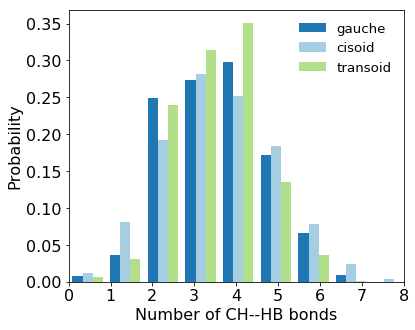

In [2]:
d1 = np.loadtxt('gauche/bonds.dat')
d2 = np.loadtxt('cis/bonds.dat')
d3 = np.loadtxt('trans/bonds.dat')
plt.hist([d1,d2,d3], normed=True, label=['gauche','cisoid','transoid'],
         histtype='bar', color=[cgauche, ccis, ctrans], alpha=1)

plt.xlim((0,8))
plt.xticks(np.arange(0, 9, 1))
plt.legend(loc=0, frameon=False, fontsize='small')
plt.xlabel('Number of CH--HB bonds')
plt.ylabel('Probability')
plt.savefig('bonds.png', bbox_inches='tight', dpi=300)

## Angular correlations between two cosan molecules

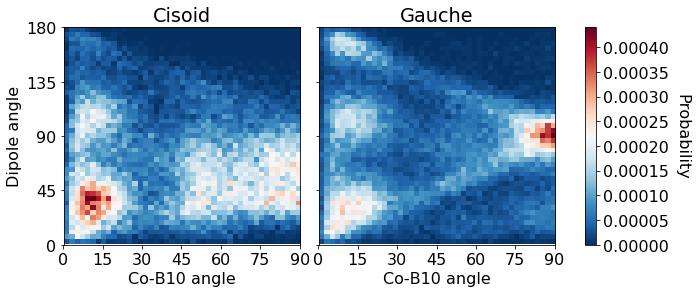

In [3]:
def plotangles(file, ax):
    x,y = np.loadtxt(file, usecols=(0,1), unpack=True)
    H, xedges, yedges, img = ax.hist2d(x, y, bins=45, cmin=0, cmax=0.00045, normed=True, cmap=plt.get_cmap('RdBu_r'))
    ax.set_xlabel('Co-B10 angle')
    ax.set_ylabel('Dipole angle')
    return img

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(4)
f.set_figwidth(11)
plotangles('cis/ang.dat', ax1)
img = plotangles('gauche/ang.dat', ax2)

f.subplots_adjust(wspace=0.08)
ax2.set_ylabel('')
ax1.set_title('Cisoid')
ax2.set_title('Gauche')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(45))
ax1.set_ylim(0,180)
ax2.set_ylim(0,180)

cbar = f.colorbar(img, ax=[ax1,ax2])
cbar.set_label('Probability', rotation=270, labelpad=20)

plt.savefig('angles.png', bbox_inches='tight', dpi=300)

## Potentials of mean force or free energy of interaction

The simulated PMFs (umbrella sampling MD) are extracted from the xmgrace file `pmfs.xvg` using a custom module for importing `.xvg` files.

In [4]:
dd = []
d = grace.LoadGrace('pmfs.xvg')
for i in range(0, len(d)):
    legend = d.legends()[i]
    comment = d.comments()[i]
    x,y = d.sets()[i].T
    dd.append( dict(x=x, y=y, comment=comment, legend=legend) )

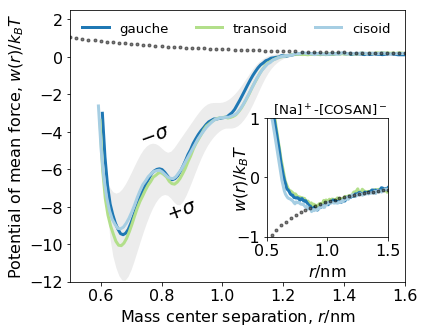

In [5]:
alpha=0.3
lw=3

# fill between +/- sigma
r1, w1 = dd[1]['x'], dd[1]['y'] # cisoid-minus
r2, w2 = dd[8]['x'], dd[8]['y'] # transoid-plus
spl1 = UnivariateSpline(r1, w1)
spl2 = UnivariateSpline(r2, w2)
spl1.set_smoothing_factor(0.5)
spl2.set_smoothing_factor(0.5)
r = np.linspace(0.61, 1.6, 100)
plt.fill_between(r, spl1(r), spl2(r),interpolate=True, alpha=0.15, color='grey', lw=0)

# smaller sigma
if (False):
    r, w, label = dd[1]['x'], dd[1]['y'], 'cisoid-minus'
    plt.plot(r,w, lw=2, ls='--', alpha=alpha, c=ccis)
    r, w, label = dd[4]['x'], dd[4]['y'], 'gauche-minus'
    plt.plot(r,w, lw=2, ls='--', alpha=alpha, c=cgauche)
    r, w, label = dd[7]['x'], dd[7]['y'], 'transoid-minus'
    plt.plot(r,w, lw=2, ls='--', alpha=alpha, c=ctrans)

# bigger sigma
if (False):
    r, w, label = dd[2]['x'], dd[2]['y'], 'cisoid-plus'
    plt.plot(r,w, lw=2, ls='--', alpha=alpha, c=ccis)
    r, w, label = dd[5]['x'], dd[5]['y'], 'gauche-plus'
    plt.plot(r,w, lw=2, ls='--', alpha=alpha, c=cgauche)
    r, w, label = dd[8]['x'], dd[8]['y'], 'transoid-plus'
    plt.plot(r,w, lw=2, ls='--', alpha=alpha, c=ctrans)

# normal sigma
r, w, label = dd[3]['x'], dd[3]['y'], 'gauche'
plt.plot(r,w, lw=lw, label=label, c=cgauche)
r, w, label = dd[6]['x'], dd[6]['y'], 'transoid'
plt.plot(r,w, lw=lw, label=label, c=ctrans)
r, w, label = dd[0]['x'], dd[0]['y'], 'cisoid'
plt.plot(r,w, lw=lw, label=label, c=ccis)

r, w, label = dd[9]['x'], dd[9]['y'], 'Yukawa'
plt.plot(r,w, 'k.', markevery=20, alpha=0.5)
plt.legend(loc=2, frameon=False, fontsize='small', framealpha=0.7, ncol=3)
plt.xlim((0.5, 1.6))
plt.ylim((-12,2.5))

plt.ylabel(r'Potential of mean force, $w(r)/k_BT$')
plt.xlabel(r'Mass center separation, $r$/nm')
plt.text(0.72, -4.2, r'$-\sigma$', fontsize='large', rotation=20)
plt.text(0.81, -8.2, r'$+\sigma$', fontsize='large', rotation=20)

# inset with sodium-cosan PMF
a = plt.axes([0.58, 0.25, .28, .33])

r, w = dd[12]['x'], dd[12]['y'] # 'transoid'
plt.plot(r,w, lw=lw, c=ctrans)
r, w = dd[11]['x'], dd[11]['y'] # 'gauche'
plt.plot(r,w, lw=lw, c=cgauche)
r, w = dd[10]['x'], dd[10]['y'] # 'cisoid'
plt.plot(r,w, lw=lw, c=ccis)
r, w = dd[13]['x'], dd[13]['y'] # 'Yukawa'
plt.plot(r,w, 'k.', markevery=40, alpha=0.5)

plt.ylabel(r'$w(r)/k_BT$', verticalalignment='top')
plt.xlabel(r'$r$/nm', )
plt.xlim((0.5,1.5))
plt.ylim((-1,1))
plt.text(0.55, 1.05, r'[Na]$^+$-[COSAN]$^-$', fontsize='small')
plt.savefig('pmf.png', bbox_inches='tight', dpi=300)

## Simple aggregation model

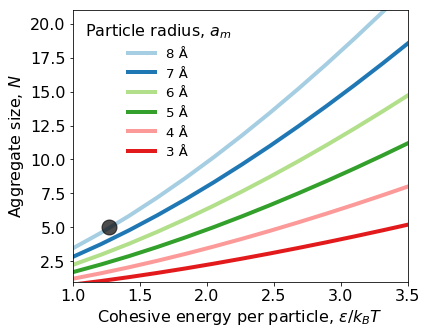

In [6]:
sizelist=[8,7,6,5,4,3 ] # angstrom
lB=7             # angstrom, Bjerrum length
z=1              # valency
D=3.04/sqrt(0.020) # angstrom, Debye length
epsilon=np.linspace(1,5,20)

def guessN():
    return (2*epsilon*am/z**2/lB)**1.5
def B2(N): # simple balance with Debye-Huckel salt
    ac = am*N**(1/3.)
    return lB*(z*N)**2/2 * (1/ac - 1/(ac+D) ) - epsilon*N
def N2(): # aggregate size via numerical solving B2
    return scipy.optimize.fsolve(B2, guessN(), xtol=1e-14 )

cnt=0
for am in sizelist:
    color=clist[cnt]
    cnt=cnt+1
    plt.plot( epsilon, (2*epsilon*am/z**2/lB)**1.5, lw=4, label=str(am)+r' Å', color=color )

# plot results for salt
if (False):
    cnt=0
    for am in sizelist:
        color=clist[cnt]
        cnt=cnt+1
        plt.plot( epsilon, N2(), '--', lw=3, color=color)
    
plt.plot( [15.9/5/2.5], [5], marker='o', ms=15, color='k', alpha=0.7) # experimental point

plt.xlabel(r'Cohesive energy per particle, $\epsilon/k_BT$')
plt.ylabel(r'Aggregate size, $N$')
plt.legend(loc=0, fontsize='small', frameon=False, title='Particle radius, $a_m$')
plt.xlim(1,3.5)
plt.ylim(1,21)
plt.savefig('cluster.png', bbox_inches='tight', dpi=300)